In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'satellite-image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1544742%2F2546969%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240524%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240524T070515Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3e03d3fde16e575e185a979563d97039120c6ba43f36be5ffd52c892765006317a0abf9f72a8561a668510d8f1c4e4bbab0b18c8f59f096f1922054d24ebfdedf1058e13c88287083fe1af2bfb3907425cde79254752dfbc27825ad5cf8eb7433e93097180389d24ee4a3cd31bc6c83bdb5bee24bc58d04186053459e267f4ce5d22a6a21b2b84b5c52b5dc053133b9eed8ac602d0833a1658e520f0fe91b245dd73adbaddcee877de19d7710d98f29449149ae89c384b5ae5bd943891cd12bbf78cf9b09a6192d0051af5fda59b1849b841b223b8ca4b5319c39ce1ae2603403f5fada8fec4acb2abc8aadb20010097bcb197e655a24f7e83df798961857409'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 22836290 bytes downloaded
Downloaded and uncompressed: satellite-image-classification
Data source import complete.


In [ ]:
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

class CustomDataset(Dataset):

    def __init__(self, root, transformations = None):

        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*"))]

        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1

    def get_class(self, path): return os.path.dirname(path).split("/")[-1]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None: im = self.transformations(im)

        return im, gt

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):

    ds = CustomDataset(root = root, transformations = transformations)

    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "/kaggle/input/satellite-image-classification/data"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

159
9
283
{'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


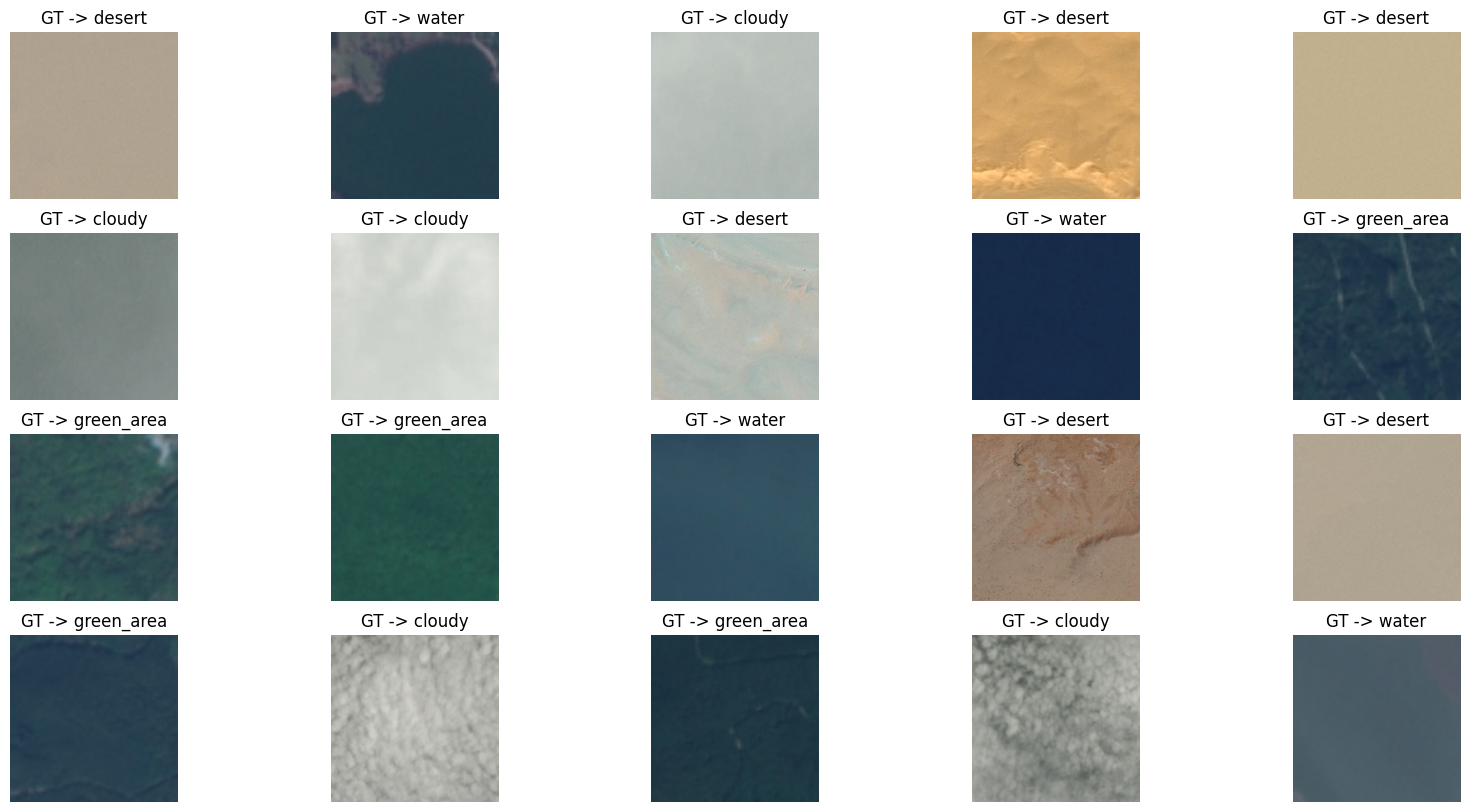

In [ ]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

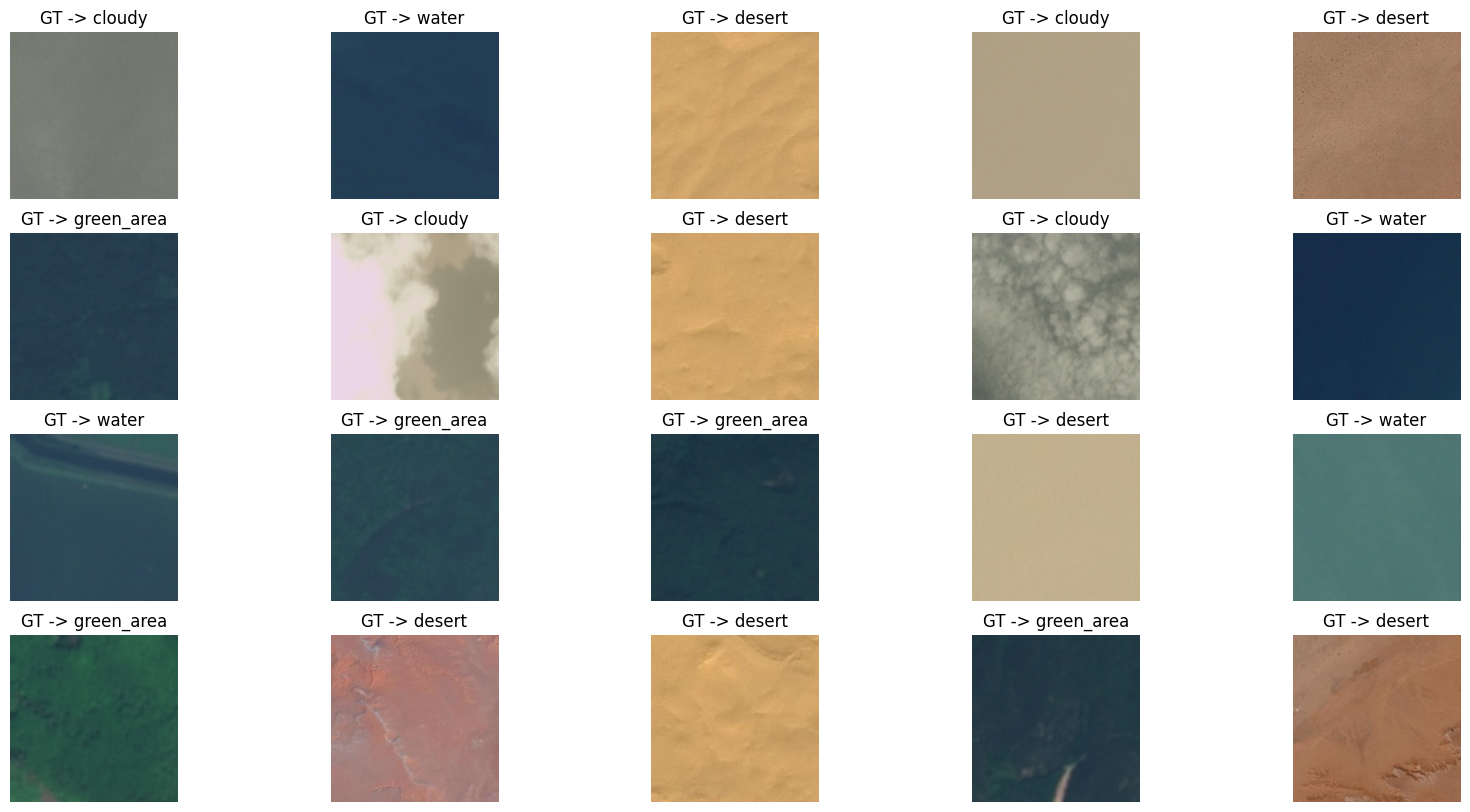

In [ ]:
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

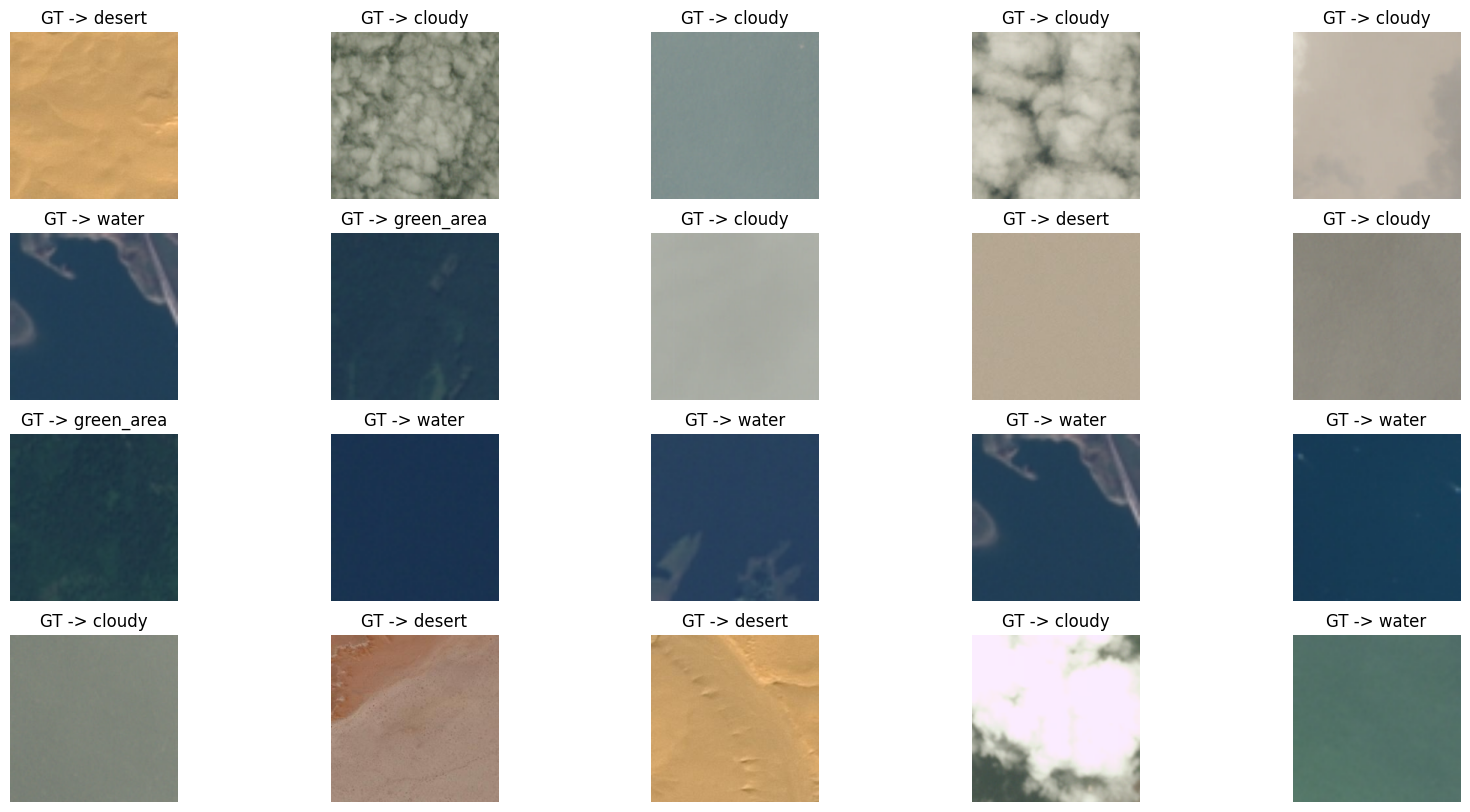

In [ ]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

<ipython-input-6-89b0e37fe94c>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 60)


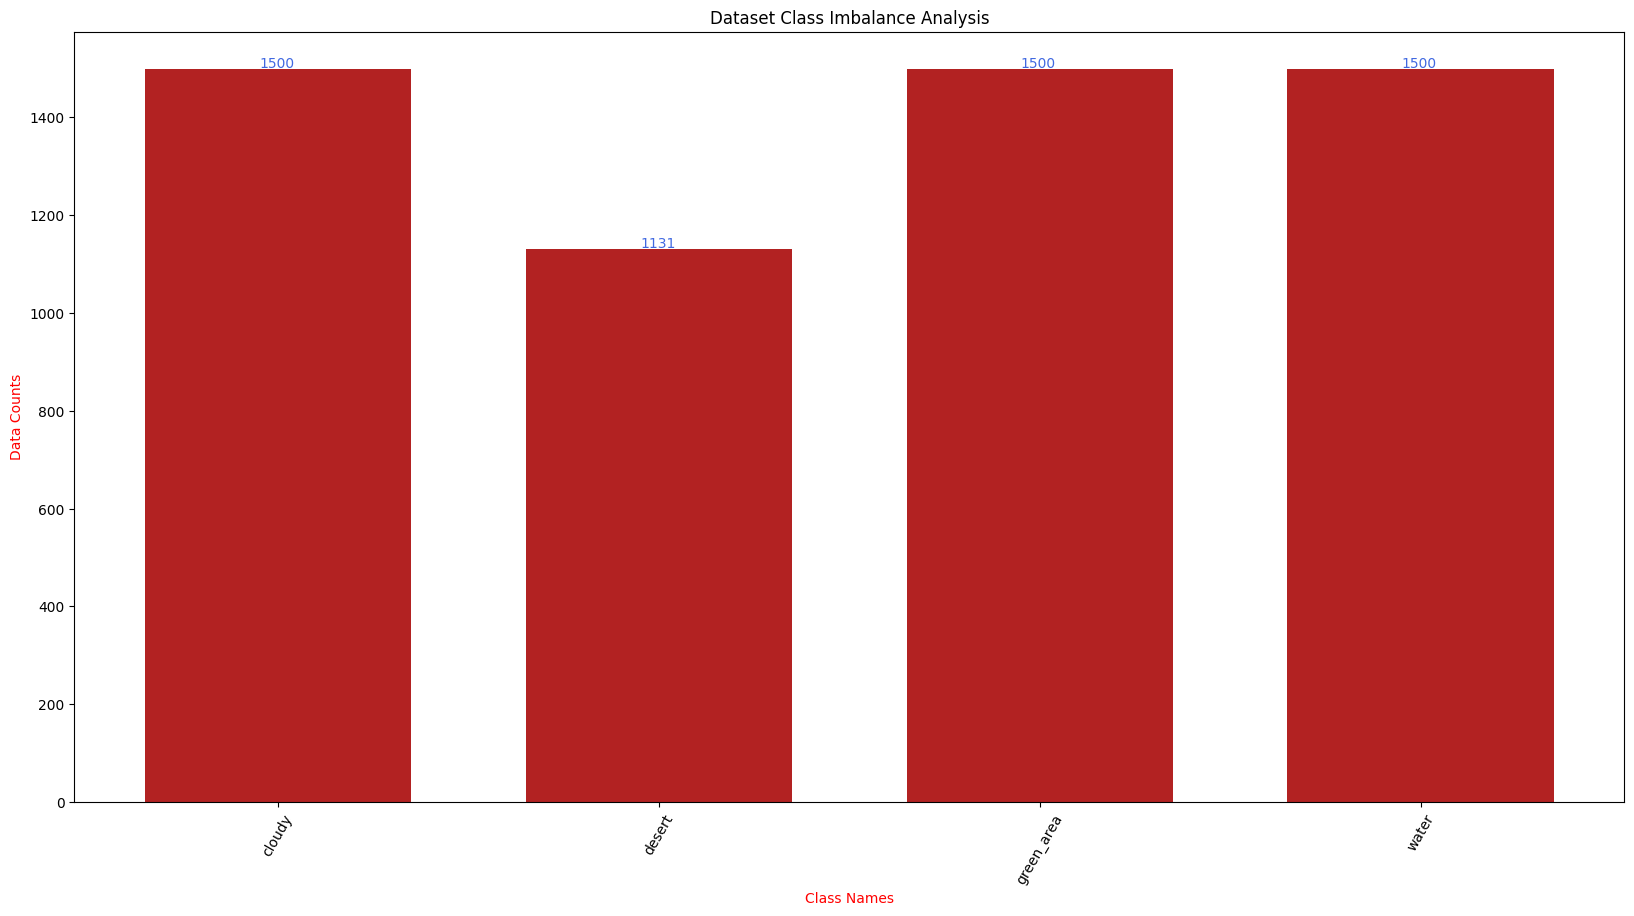

In [ ]:
def data_analysis(root, transformations):

    ds = CustomDataset(root = root, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")

data_analysis(root = root, transformations = tfs)

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.8 MB/s eta 0:00:00


In [ ]:
import timm, torchmetrics
from tqdm import tqdm
m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))

def train_setup(m): return m.to("cuda").eval(), 10, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "satellite", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)

for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc  / len(val_dl.dataset)
        val_f1_to_track   = val_epoch_f1   / len(val_dl)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track); val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Start training...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
158it [00:38,  4.96it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
159it [00:38,  4.11it/s]

1-epoch train process is completed!
1-epoch train loss          -> 0.221
1-epoch train accuracy      -> 0.953
1-epoch train f1-score      -> 0.953


1-epoch validation process is completed!
1-epoch validation loss     -> 0.000
1-epoch validation accuracy -> 1.000
1-epoch validation f1-score -> 1.000


159it [00:33,  4.77it/s]

2-epoch train process is completed!
2-epoch train loss          -> 0.039
2-epoch train accuracy      -> 0.990
2-epoch train f1-score      -> 0.990


2-epoch validation process is completed!
2-epoch validation loss     -> 0.009
2-epoch validation accuracy -> 1.000
2-epoch validation f1-score -> 1.000


159it [00:34,  4.61it/s]

3-epoch train process is completed!
3-epoch train loss          -> 0.110
3-epoch train accuracy      -> 0.977
3-epoch train f1-score      -> 0.977


3-epoch validation process is completed!
3-epoch validation loss     -> 0.000
3-epoch validation accuracy -> 1.000
3-epoch validation f1-score -> 1.000


159it [00:34,  4.62it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.045
4-epoch train accuracy      -> 0.990
4-epoch train f1-score      -> 0.990


4-epoch validation process is completed!
4-epoch validation loss     -> 0.001
4-epoch validation accuracy -> 1.000
4-epoch validation f1-score -> 1.000


159it [00:34,  4.66it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.013
5-epoch train accuracy      -> 0.996
5-epoch train f1-score      -> 0.996


5-epoch validation process is completed!
5-epoch validation loss     -> 0.000
5-epoch validation accuracy -> 1.000
5-epoch validation f1-score -> 1.000


159it [00:34,  4.64it/s]

6-epoch train process is completed!
6-epoch train loss          -> 0.005
6-epoch train accuracy      -> 0.998
6-epoch train f1-score      -> 0.998


6-epoch validation process is completed!
6-epoch validation loss     -> 0.004
6-epoch validation accuracy -> 1.000
6-epoch validation f1-score -> 1.000


159it [00:34,  4.58it/s]

7-epoch train process is completed!
7-epoch train loss          -> 0.002
7-epoch train accuracy      -> 0.999
7-epoch train f1-score      -> 0.999


7-epoch validation process is completed!
7-epoch validation loss     -> 0.000
7-epoch validation accuracy -> 1.000
7-epoch validation f1-score -> 1.000


159it [00:34,  4.64it/s]

8-epoch train process is completed!
8-epoch train loss          -> 0.001
8-epoch train accuracy      -> 0.999
8-epoch train f1-score      -> 0.999


8-epoch validation process is completed!
8-epoch validation loss     -> 0.000
8-epoch validation accuracy -> 1.000
8-epoch validation f1-score -> 1.000


159it [00:34,  4.64it/s]

9-epoch train process is completed!
9-epoch train loss          -> 0.027
9-epoch train accuracy      -> 0.994
9-epoch train f1-score      -> 0.994


9-epoch validation process is completed!
9-epoch validation loss     -> 0.000
9-epoch validation accuracy -> 1.000
9-epoch validation f1-score -> 1.000


159it [00:34,  4.61it/s]

10-epoch train process is completed!
10-epoch train loss          -> 0.027
10-epoch train accuracy      -> 0.993
10-epoch train f1-score      -> 0.993


10-epoch validation process is completed!
10-epoch validation loss     -> 0.000
10-epoch validation accuracy -> 1.000
10-epoch validation f1-score -> 1.000


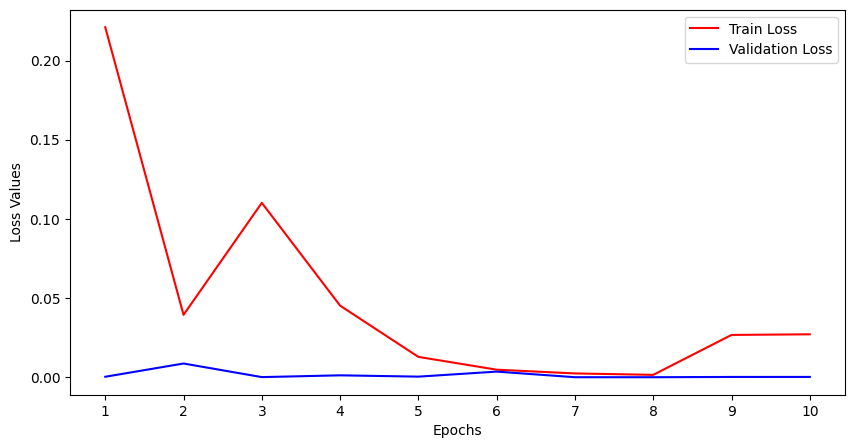

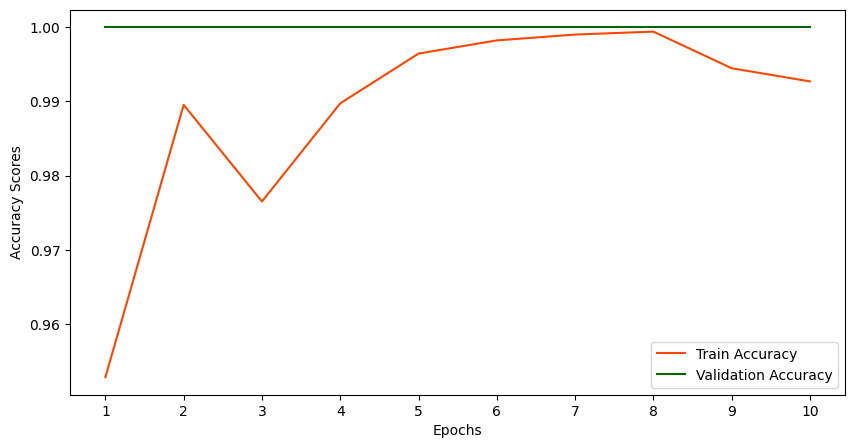

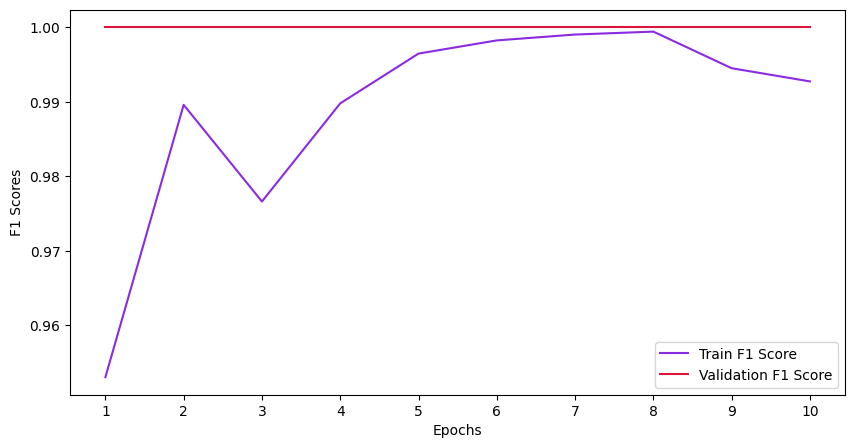

In [ ]:
class PlotLearningCurves:

    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):

        self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s

    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):

        plt.plot(array_1, label = label_1, c = color_1); plt.plot(array_2, label = label_2, c = color_2)

    def create_figure(self): plt.figure(figsize = (10, 5))

    def decorate(self, ylabel, xlabel = "Epochs"):

        plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_accs)), labels = [i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend(); plt.show()

    def visualize(self):

        # Figure 1
        self.create_figure()
        self.plot(array_1 = self.tr_losses, array_2 = self.val_losses, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = "red", color_2 = "blue"); self.decorate(ylabel = "Loss Values")

        # Figure 2
        self.create_figure()
        self.plot(array_1 = self.tr_accs, array_2 = self.val_accs, label_1 = "Train Accuracy", label_2 = "Validation Accuracy", color_1 = "orangered", color_2 = "darkgreen")
        self.decorate(ylabel = "Accuracy Scores")

        # Figure 3
        self.create_figure()
        self.plot(array_1 = [tr_f1.cpu() for tr_f1 in self.tr_f1s], array_2 = [vl_f1.cpu() for vl_f1 in self.val_f1s], label_1 = "Train F1 Score", label_2 = "Validation F1 Score", color_1 = "blueviolet", color_2 = "crimson"); self.decorate(ylabel = "F1 Scores")

PlotLearningCurves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s).visualize()

283it [00:06, 42.68it/s]


Accuracy of the model on the test data -> 0.993


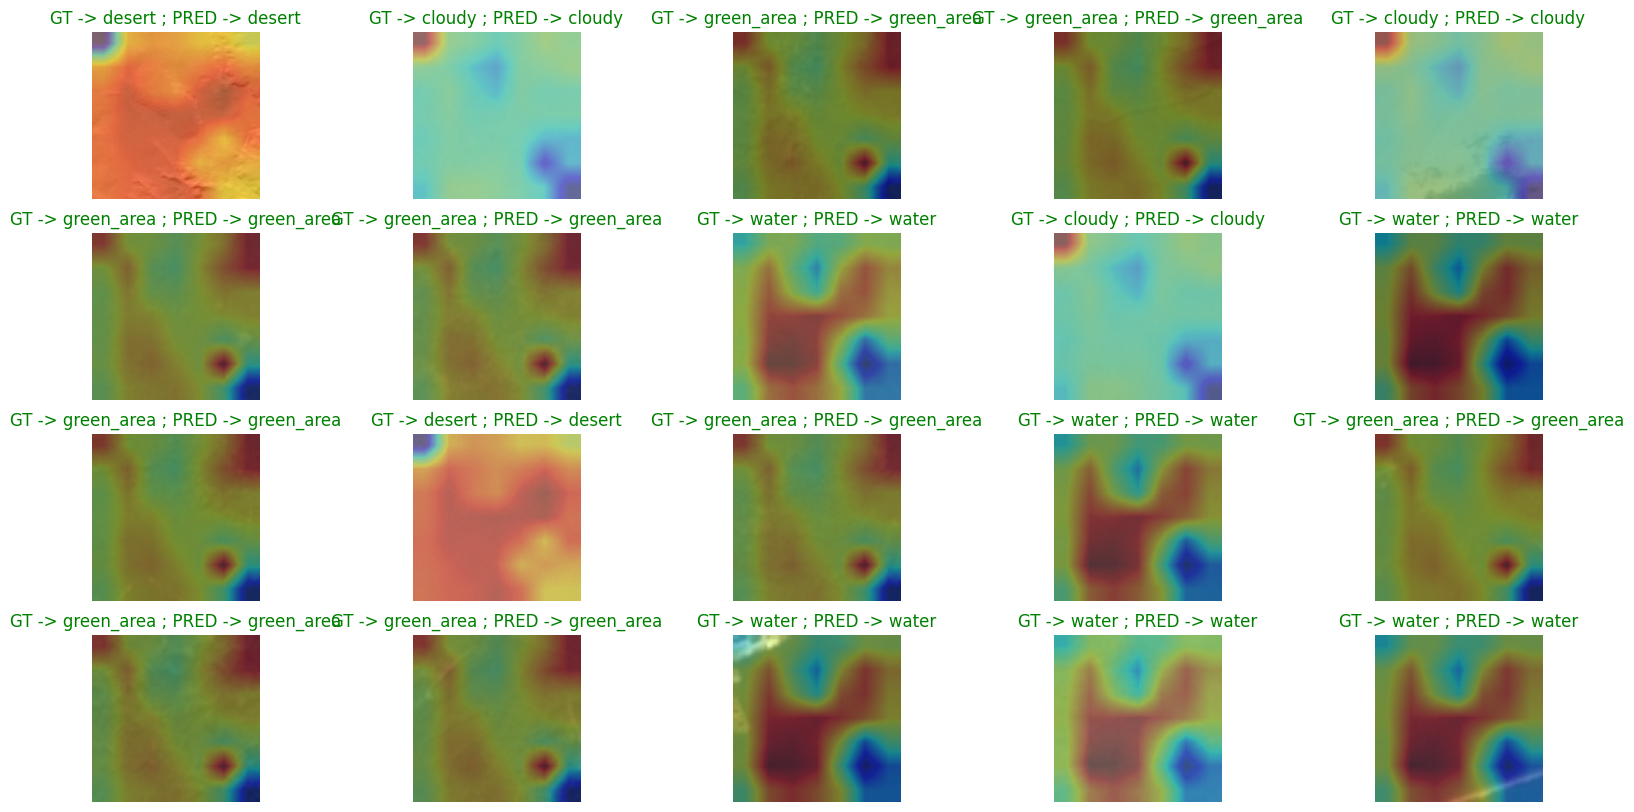

In [ ]:
import cv2
class SaveFeatures():

    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):

    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)

    return (cam - np.min(cam)) / np.max(cam)

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):

    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        im, gt = to_device(batch, device)
        pred_class = torch.argmax(model(im), dim = 1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())

    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]

    for idx, indeks in enumerate(indekslar):

        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)

        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (im_size, im_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet'); plt.axis("off")

        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")

m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(model = m.to(device), device = device, test_dl = ts_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv = final_conv, fc_params = fc_params)